In [2]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import requests
import json

In [24]:
#function to save data in json format
def save_json(loc, data, mode = 'w'):
    with open(loc,mode) as json_data:
        json.dump(data, json_data)

## Extracting channel deetails

**Extracting channel_id**

In [25]:
from bs4 import BeautifulSoup

youtubers = {'krishnaik':{'username':'krishnaik06'},
            'Hitesh':{'username':'HiteshChoudharydotcom'},
            'mysirji':{'username':'saurabhexponent1'},
            'Telusko':{'username':'javaboynavin'}}
channel_ids = []

for youtuber in youtubers:
    
    #making request to the webpage
    url = "https://www.youtube.com/user/" + youtubers[youtuber]['username']
    response = requests.get(url)
    
    if response.ok ==True:
        #parse the HTML content with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
    else:
        url = "https://www.youtube.com/c/" + youtubers[youtuber]['username']
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
    #We then use the find() method to search for the canonical link tag, specifying the link tag name and the rel attribute value of 'canonical'.
    canonical_link = soup.find('link', rel = 'canonical')
    #then we extract the 'href' attribute value of the canonical link tag
    canonical_url = canonical_link['href']
    #then getting the channel_id
    channel_id = canonical_url.split('/')[-1]
    channel_ids.append(channel_id)
channel_ids

['UCNU_lfiiWBdtULKOw6X0Dig',
 'UCXgGY0wkgOzynnHvSEVmE3A',
 'UCkGS_3D0HEzfflFnG0bD24A',
 'UC59K-uG2A5ogwIrHw4bmlEg']

In [26]:
##api_key
api_key = ''

In [27]:
#setup the API client
youtube = build('youtube', 'v3', developerKey= api_key) 

**channel statistics**

In [28]:
def get_channel_stats(youtube, channel_ids):
    request = youtube.channels().list(
              part = 'id, snippet, contentDetails, statistics', 
              id = ','.join(channel_ids))          ##passing all the channel ids in a string separated by ','
    response = request.execute()                   ####the response is in dictionary format, in that we see pageinfo we will find we gor four results w.r.t each yotuber then in the 'items', i willfind 4 dictionaries in a list, ach dictionary have details of each youtuber whose id we passed in the request{we undestand all thsi by opening that data in json formatter} 
    all_data = []
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
               Subscribers = response['items'][i]['statistics']['subscriberCount'],
               Views = response['items'][i]['statistics']['viewCount'],
               Total_videos = response['items'][i]['statistics']['videoCount'],
               playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    return all_data

In [29]:
channel_statistics = get_channel_stats(youtube, channel_ids)
channel_data = pd.DataFrame(channel_statistics)

In [30]:
channel_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,Hitesh Choudhary,780000,51462315,1342,UUXgGY0wkgOzynnHvSEVmE3A
1,Krish Naik,737000,72979478,1648,UUNU_lfiiWBdtULKOw6X0Dig
2,Telusko,1960000,226306590,1761,UU59K-uG2A5ogwIrHw4bmlEg
3,MySirG.com,819000,90958256,1360,UUkGS_3D0HEzfflFnG0bD24A


In [31]:
##for visulisation of data, first of all we will ahve to convert the datatype in into integer
channel_data['Subscribers']= channel_data['Subscribers'].astype(int)
channel_data['Views']= channel_data['Views'].astype(int)
channel_data['Total_videos']= channel_data['Total_videos'].astype(int)

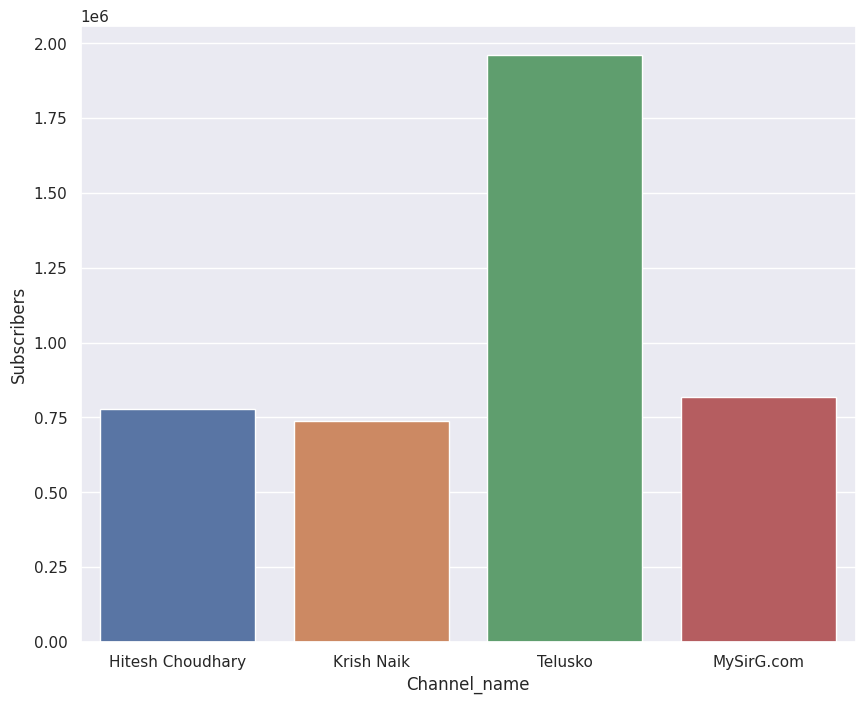

In [32]:
sns.set(rc ={'figure.figsize':(10,8)})
ax = sns.barplot(x= 'Channel_name', y = 'Subscribers',data = channel_data)

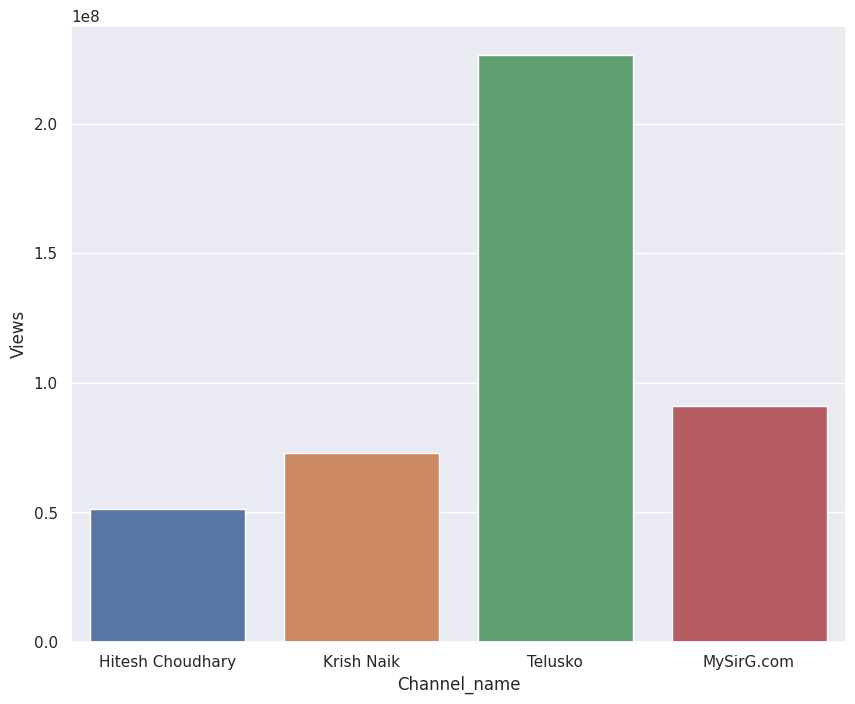

In [33]:
sns.set(rc ={'figure.figsize':(10,8)})
ax = sns.barplot(x= 'Channel_name', y = 'Views',data = channel_data)

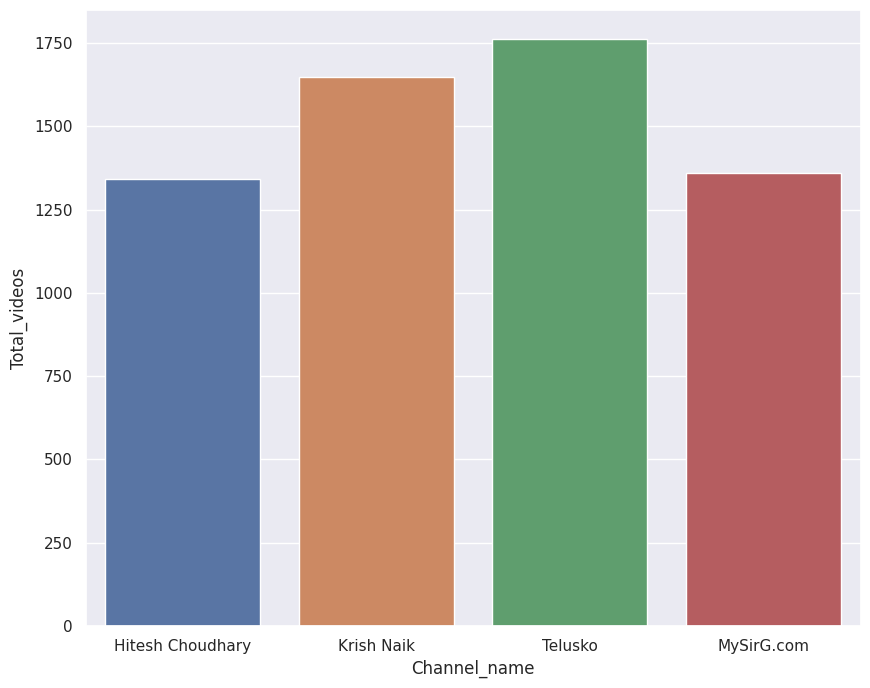

In [34]:
sns.set(rc ={'figure.figsize':(10,8)})
ax = sns.barplot(x= 'Channel_name', y = 'Total_videos',data = channel_data)

**Function to fetch video_ids for 50 videos of all the four youtubers**

In [35]:
def get_video_ids(youtube, channel_data):
    video_ids = []
    for playlist_id in channel_data['playlist_id']:
        request = youtube.playlistItems().list(
            part = 'contentDetails',
            playlistId = playlist_id,
            maxResults = 50)
        response = request.execute()
         
        for i in range(len(response['items'])):
            video_ids.append(response['items'][i]['contentDetails']['videoId'])
    return video_ids

In [36]:
video_ids = get_video_ids(youtube, channel_data)

In [37]:
len(video_ids)

200

**Functions to get video details**

In [38]:
def get_video_details(youtube, video_ids):
    
    all_video_stats= []
    for i in range(0,len(video_ids), 50):
        #requesting video details
        request= youtube.videos().list(
              part = 'snippet, statistics, player',
               id = ','.join(video_ids[i:i+50]))
        response = request.execute()
        
        for video_id, video in zip(video_ids[i:i+50], response['items']):
            video_stats = dict(channel_Title = video['snippet']['channelTitle'],
                               video_id = video_id,
                                Title = video['snippet']['title'],
                               Thumbnail_url = video['snippet']['thumbnails']['medium']['url'],
                               Published_date = video['snippet']['publishedAt'],
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics']['likeCount'],
                               Comment_count = video['statistics'].get('commentCount', 0))
            
            #extract the video's URL from the player information if available
            if 'player' in video:
                player_info = video['player']['embedHtml']
                embed_url = player_info.split('src="')[1].split('"')[0].replace('\/','/')                      ##the URL includes '//' prefix, which indicates that the video url should use the same protocol(http or https) as the page that si embedding the video, if you want to specify partivular protocol you can modify the URL,,,,,,,,,,and we replace `'\/'` with `'/'` because the youtube API sometimes encodes forward slashes in URLs as `'\/'` in order to prevent them from being interpreted as json escape characters
                video_stats['video_url'] = "https:" + embed_url
            else:
                video_stats['video_url']='Not available'
            
            all_video_stats.append(video_stats)
            
    return all_video_stats

In [39]:
video_details = get_video_details(youtube, video_ids)
video_data = pd.DataFrame(video_details)

In [40]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Comment_count'] = pd.to_numeric(video_data['Comment_count'])

In [41]:
video_data

,channel_Title,video_id,Title,Thumbnail_url,Published_date,Views,Likes,Comment_count,video_url
0,Hitesh Choudhary,Hb5rh9vXNyY,Social Media Revolution Launch,https://i.ytimg.com/vi/Hb5rh9vXNyY/mqdefault.jpg,2023-04-01,4278,475,157,https://www.youtube.com/embed/Hb5rh9vXNyY
1,Hitesh Choudhary,ItKjzteWXFg,#harpaymentdigital is a great initiative by RB...,https://i.ytimg.com/vi/ItKjzteWXFg/mqdefault.jpg,2023-03-24,4838,515,14,https://www.youtube.com/embed/ItKjzteWXFg
2,Hitesh Choudhary,5Qlep9sKuX4,Project 6 | What next to build in React Native,https://i.ytimg.com/vi/5Qlep9sKuX4/mqdefault.jpg,2023-03-23,3414,84,9,https://www.youtube.com/embed/5Qlep9sKuX4
3,Hitesh Choudhary,-4jSSxoGOSs,"Here is an security first, open source passwor...",https://i.ytimg.com/vi/-4jSSxoGOSs/mqdefault.jpg,2023-03-22,5874,250,6,https://www.youtube.com/embed/-4jSSxoGOSs
4,Hitesh Choudhary,bIJASPiSKS4,Handling errors in Haptic Feedback in React Na...,https://i.ytimg.com/vi/bIJASPiSKS4/mqdefault.jpg,2023-03-20,1415,58,6,https://www.youtube.com/embed/bIJASPiSKS4
...,...,...,...,...,...,...,...,...,...
195,MySirG.com,qgNnf1GMLxc,Yeh channel dekha kya?,https://i.ytimg.com/vi/qgNnf1GMLxc/mqdefault.jpg,2022-08-12,9062,658,44,https://www.youtube.com/embed/qgNnf1GMLxc
196,MySirG.com,-Po6d6Zm3cE,Decision Control in Python | LIVE Community Cl...,https://i.ytimg.com/vi/-Po6d6Zm3cE/mqdefault.jpg,2022-08-11,18929,665,25,https://www.youtube.com/embed/-Po6d6Zm3cE
197,MySirG.com,2D7uw4ghr88,"Keywords, Operators and User input in Python |...",https://i.ytimg.com/vi/2D7uw4ghr88/mqdefault.jpg,2022-08-10,24794,912,30,https://www.youtube.com/embed/2D7uw4ghr88
198,MySirG.com,ppKaxLop79c,Variables and Types in Python | LIVE Community...,https://i.ytimg.com/vi/ppKaxLop79c/mqdefault.jpg,2022-08-09,32357,1319,56,https://www.youtube.com/embed/ppKaxLop79c


In [21]:
video_data.to_csv('Video_details.csv',index = False)

In [22]:
save_json("video_details.json", video_details)

**Getting all comments, commentators and replies for all videos**

In [42]:
##function to get comment items
def get_comment_items(youtube, video_id, nextPageToken= None):
    items = []
    response_comments = youtube.commentThreads().list(
                        part = 'snippet, replies',
                        videoId = video_id,
                        pageToken = nextPageToken
                        ).execute()
    items.extend(response_comments['items'])
    
    if 'nextPageToken' in response_comments:
        response_comments1 = youtube.commentThreads().list(
                            part = 'snippet, replies',
                            videoId = video_id,
                            pageToken = response_comments['nextPageToken']
                            ).execute()
        items.extend(response_comments1['items'])
    else:
        return items
    return items     


##now extracting comment details out of items
comments_data = []
for i, video_id in enumerate(video_ids[:50]):
    try:
        response_comments = get_comment_items(youtube, video_id)
        commentCount = len(response_comments)
        comments = {
            'videoId':video_id,
            'title': video_data['Title'][i],
            'commentCount': commentCount,
            'comments': []
                    }
        for response in response_comments:
            totalReplyCount = response['snippet']['totalReplyCount']
            if totalReplyCount !=0:
                if 'replies' in response:
                    replies= []
                    for i in response['replies']['comments']:
                        iter= dict(authorname= i['snippet']['authorDisplayName'],
                              comment = i['snippet']['textOriginal'],
                              likecount= i['snippet']['likeCount'],
                              publishedAt = i['snippet']['publishedAt'])
                        replies.append(iter)
                else:
                    replies=[]
            else:
                replies =[]
            comments['comments'].append(
                                {
                                "author_Name": response['snippet']['topLevelComment']['snippet']['authorDisplayName'],
                                "comment": response['snippet']['topLevelComment']['snippet']['textOriginal'],
                                "publishedAt": response['snippet']['topLevelComment']['snippet']['publishedAt'],
                                "likeCount": response['snippet']['topLevelComment']['snippet']['likeCount'],
                                "replies": replies
                                })
    except Exception as e:
        print(e)
        comments = {
            'videoId':video_id,
            'title': video_data['Title'][i],
            'commentCount': 0,
            'comments': []
        }
    comments_data.append(comments)

In [ ]:
comments_data

[{'videoId': 'SkzmbeYCtiU',
  'title': 'Tutorial 10- Deployment Of ML Application In Azure Cloud Using Github Actions',
  'commentCount': 10,
  'comments': [{'author_Name': 'Amukelani Ebenezer',
    'comment': 'Thank you for sharing',
    'publishedAt': '2023-04-01T02:16:59Z',
    'likeCount': 0,
    'replies': []},
   {'author_Name': 'Sanket Saurabh',
    'comment': 'yes sir please make github actions playlist',
    'publishedAt': '2023-03-31T18:50:06Z',
    'likeCount': 0,
    'replies': []},
   {'author_Name': 'Melodi music',
    'comment': 'How to include all preprocessing steps in app.py using pickle. Please make a video on dataset contains missing, cat and num columns',
    'publishedAt': '2023-03-31T17:35:12Z',
    'likeCount': 0,
    'replies': []},
   {'author_Name': 'VINAYAK TIWARI',
    'comment': 'Hi Krish, how can we dockerize the whole project ? Please make a video on that also , nice tutorial by the way',
    'publishedAt': '2023-03-31T17:18:36Z',
    'likeCount': 0,
   

In [ ]:
save_json('comments_data.json',comments_data)

**convert thumbnils in base64 format**

In [43]:
import base64
thumbnails = {
            'Video_id':[],
            'Title': [],
            'Thumbnail':[]
                }
for video_id, title, thumbnail in zip(video_ids, video_data['Title'], video_data['Thumbnail_url']):
    #make a request to the image URL to get the binary data
    response = requests.get(thumbnail)
    binary_data = response.content                          ##saving them in this format as easy to transfer over network{as to transfer a file over network require additional step of encoding and decoding}, also storing them in this format is more efficient than them as file w.r.t. storage    
    
    #convert the binary data to base64                        ##helpful in situations where you need to transfer the image data over the network or store it in a database that only accepts text data,,,,although it takes more space than data in biary format, also its processing takes more time, so it sbetter to save them in binary format but since in teh task they ask me to save in base64 format thats why i am doing this,,,,also saving this in base 64 format is good idea if we need to transfer image data over a network or API that only support text-based data , or if we need to embed image data in an HTML or CSS documnet.
    base64_data = base64.b64encode(binary_data).decode('utf-8')
    
    thumbnails['Video_id'].append(video_id)
    thumbnails['Title'].append(title)
    thumbnails['Thumbnail'].append(base64_data)

In [44]:
pd.DataFrame(thumbnails).to_csv('thumnails_base64.csv')